In [1]:
# Load the "autoreload" extension
#%load_ext autoreload

#reload extension
%reload_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 2

#Import all the necessary packages for modules
import os
import sys

#add the 'python' directory as one where we can import modules
py_dir = os.path.join(os.getcwd(), 'python')
sys.path.append(py_dir)

# import my method from the source code
from python.get_info import plot_hists, plot_violin

In [2]:
#Import all necessary packages for visualization and transformation of the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# PRE-PROCESSING

In [3]:
#upload training set and change dtypes for visitor_id and label to a categorical object
train = pd.read_csv('data/train_20170701_to_20170731', index_col=0, dtype={'visitor_id': 'object'})
train.head()

visitor_id  day0_time_on_site_seconds  day1_time_on_site_seconds  \
0  3092487309701391768                      570.0                        NaN   
1   780253600713375371                      705.0                        NaN   
2   953713676730854570                      373.0                        NaN   
3   238925310298938861                     1919.0                        NaN   
4  1090774782213816251                     2405.0                        NaN   

   day2_time_on_site_seconds  day3_time_on_site_seconds  \
0                     1021.0                        NaN   
1                        NaN                        NaN   
2                        NaN                        NaN   
3                        NaN                        NaN   
4                        NaN                        NaN   

   day4_6_time_on_site_seconds  w2_time_on_site_seconds  day0_hits  day1_hits  \
0                          NaN                    533.0       26.0        NaN   
1                          NaN                   1181.0       58.0        NaN   
2                          NaN                    736.0       42.0        NaN   
3                         14.0                    691.0       74.0        NaN   
4                          0.0                    454.0       33.0        NaN   

   day2_hits  ...  day3_sessions  day4_6_sessions  w2_sessions  \
0        6.0  ...            NaN              NaN          2.0   
1        NaN  ...            NaN              NaN          1.0   
2        NaN  ...            NaN              NaN          1.0   
3        NaN  ...            NaN              1.0          2.0   
4        NaN  ...            NaN              1.0          2.0   

   day0_session_quality  day1_session_quality  day2_session_quality  \
0                  60.0                   NaN                   3.0   
1                  85.0                   NaN                   NaN   
2                  76.0                   NaN                   NaN   
3                  79.0                   NaN                   NaN   
4                  87.0                   NaN                   NaN   

   day3_session_quality  day4_6_session_quality  w2_session_quality  label  
0                   NaN                     NaN                 1.5      1  
1                   NaN                     NaN                79.0      1  
2                   NaN                     NaN                65.0      1  
3                   NaN                     1.0                43.5      1  
4                   NaN                     1.0                 3.0      1  

[5 rows x 38 columns]

In [4]:
train.label.value_counts()/len(train.label)

0    0.951713
1    0.048287
Name: label, dtype: float64

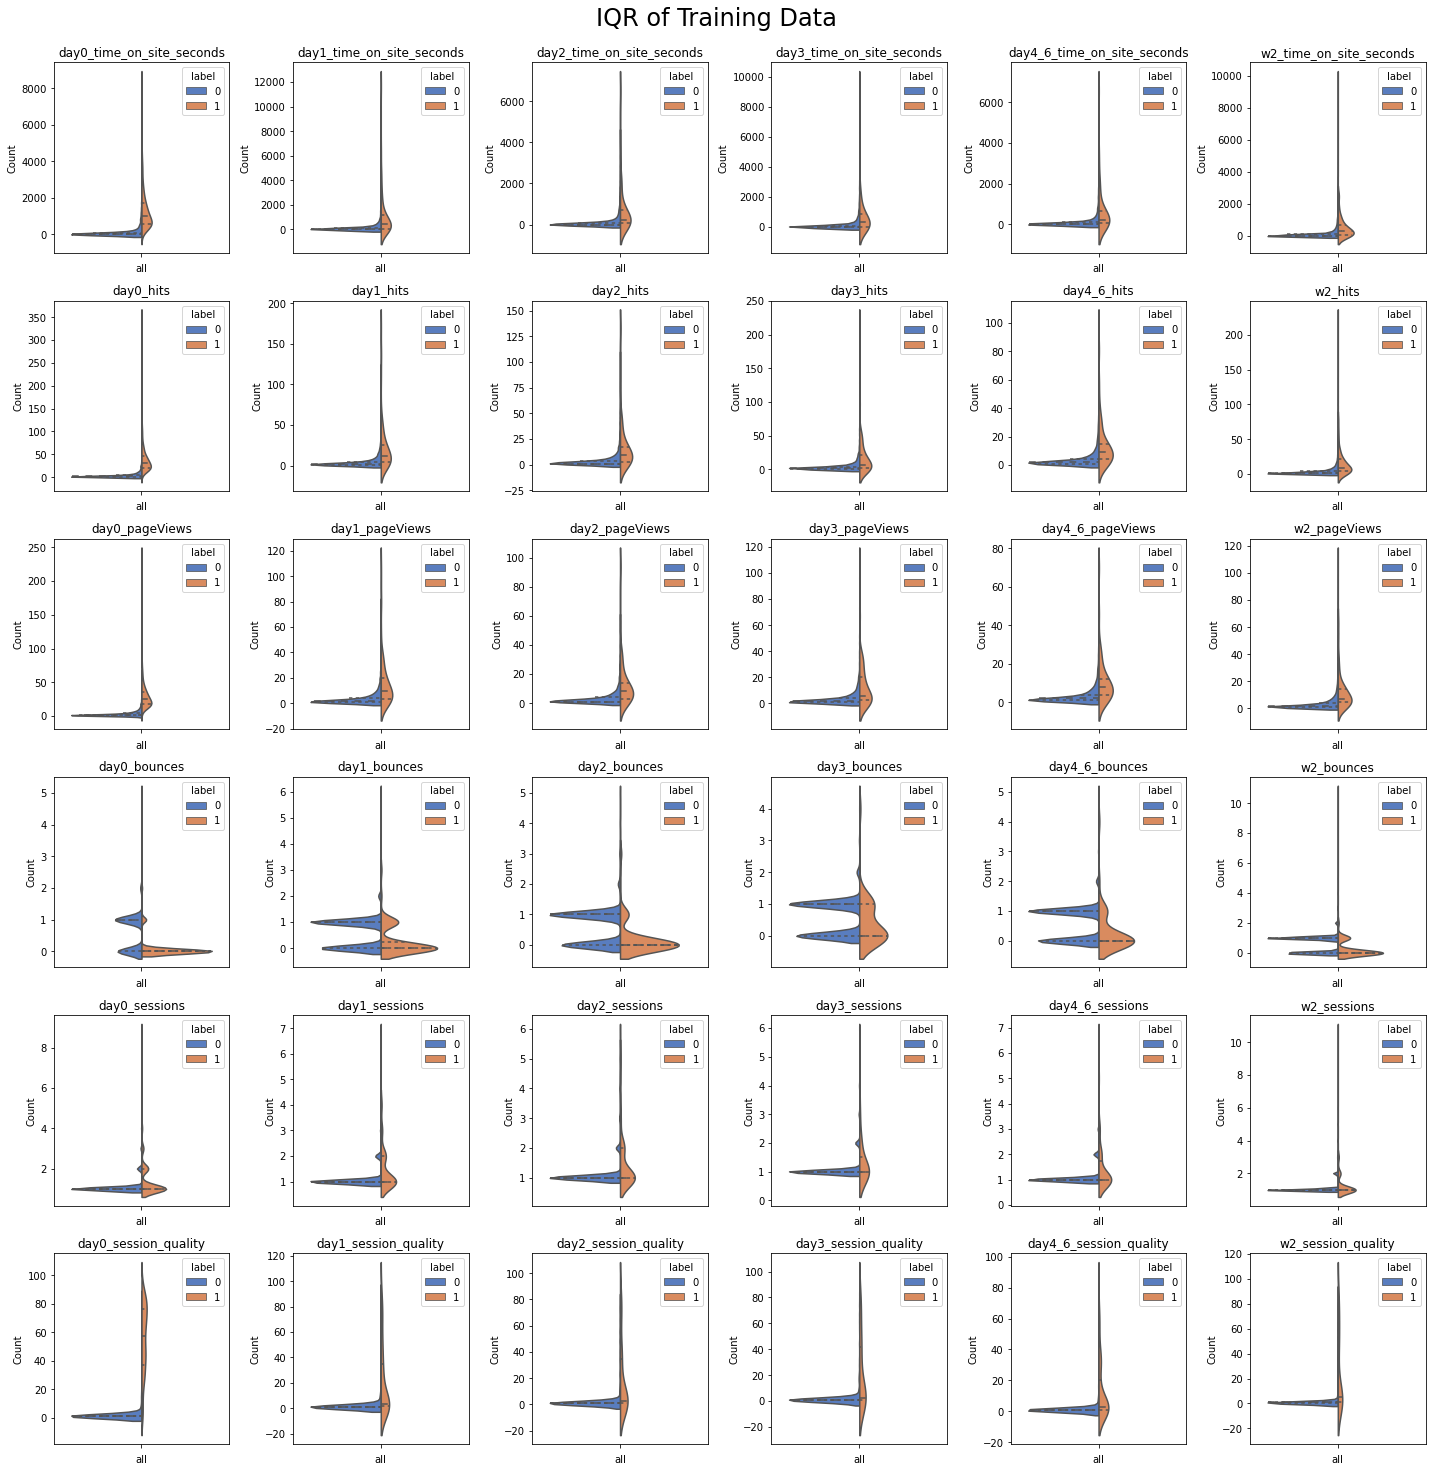

In [5]:
#create blank column to plot violin boxplot
train['all']=''

#plot violin boxplot
plot_violin(train, 'IQR of Training Data')

#remove blank column
train = train.iloc[:,:-1]

Looking at a preview of the data once again and at the percentage of customers who don't purchase (label 0) vs. customers who do purchase (label 1), we can see that customers who make a purchase make up less than 5% of the dataset despite already downsampling customers who don't purchase. In other words, the data is highly imbalanced and customers making a purchase is considered a rare event. The violin boxplot also shows that there are significant outliers in the data.

We will perform each the following pre-processing techniques to mitigate any biases and inaccuracies in predicting customer propensity:

- __Scaling (Standardization)__
- __Imputing__ - the null values in the data are meaningful; they represent the days that each visitor was _not_ present on the site. We can impute the data by filling each null value with zeroes to represent this.

### IMPUTE MISSING DATA

In [6]:
train.fillna(0, inplace=True)

### SCALE THE DATA

#### LOG-TRANSFORM

In [7]:
train_log = train.iloc[:,1:]
train_log = (train_log+1).transform(np.log)
#Negative Values Handling
#Note that the values are different
train_log = (train_log-train_log.min()+1).transform(np.log)
train_log.insert(0, 'visitor_id', train.visitor_id)
train_log['label'] = train['label']

Let's check to see what the data looks like now.

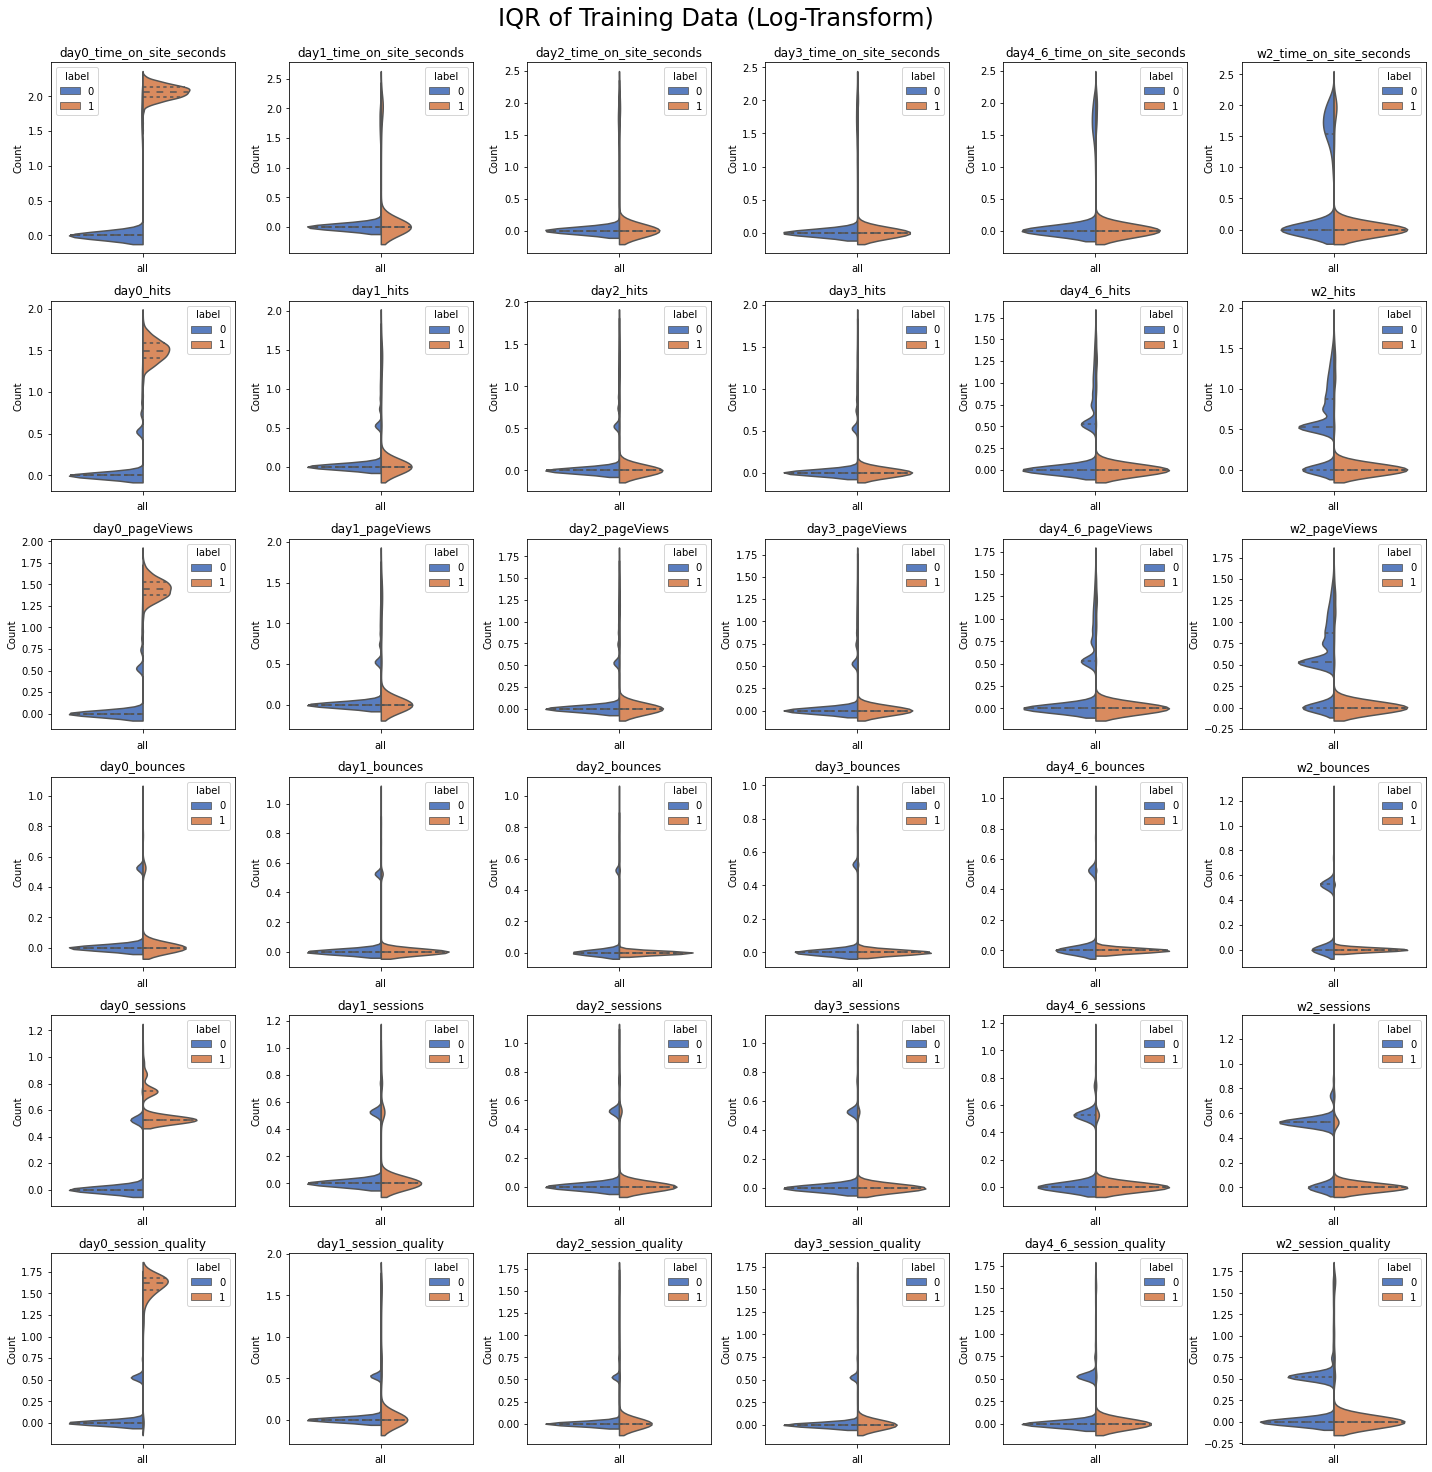

In [8]:
#log scale the data
#train_log = log_scale(train)

#create blank column to plot violin boxplot
train_log['all']=''

plot_violin(train_log, 'IQR of Training Data (Log-Transform)')

#remove blank column
train_log = train_log.iloc[:,:-1]

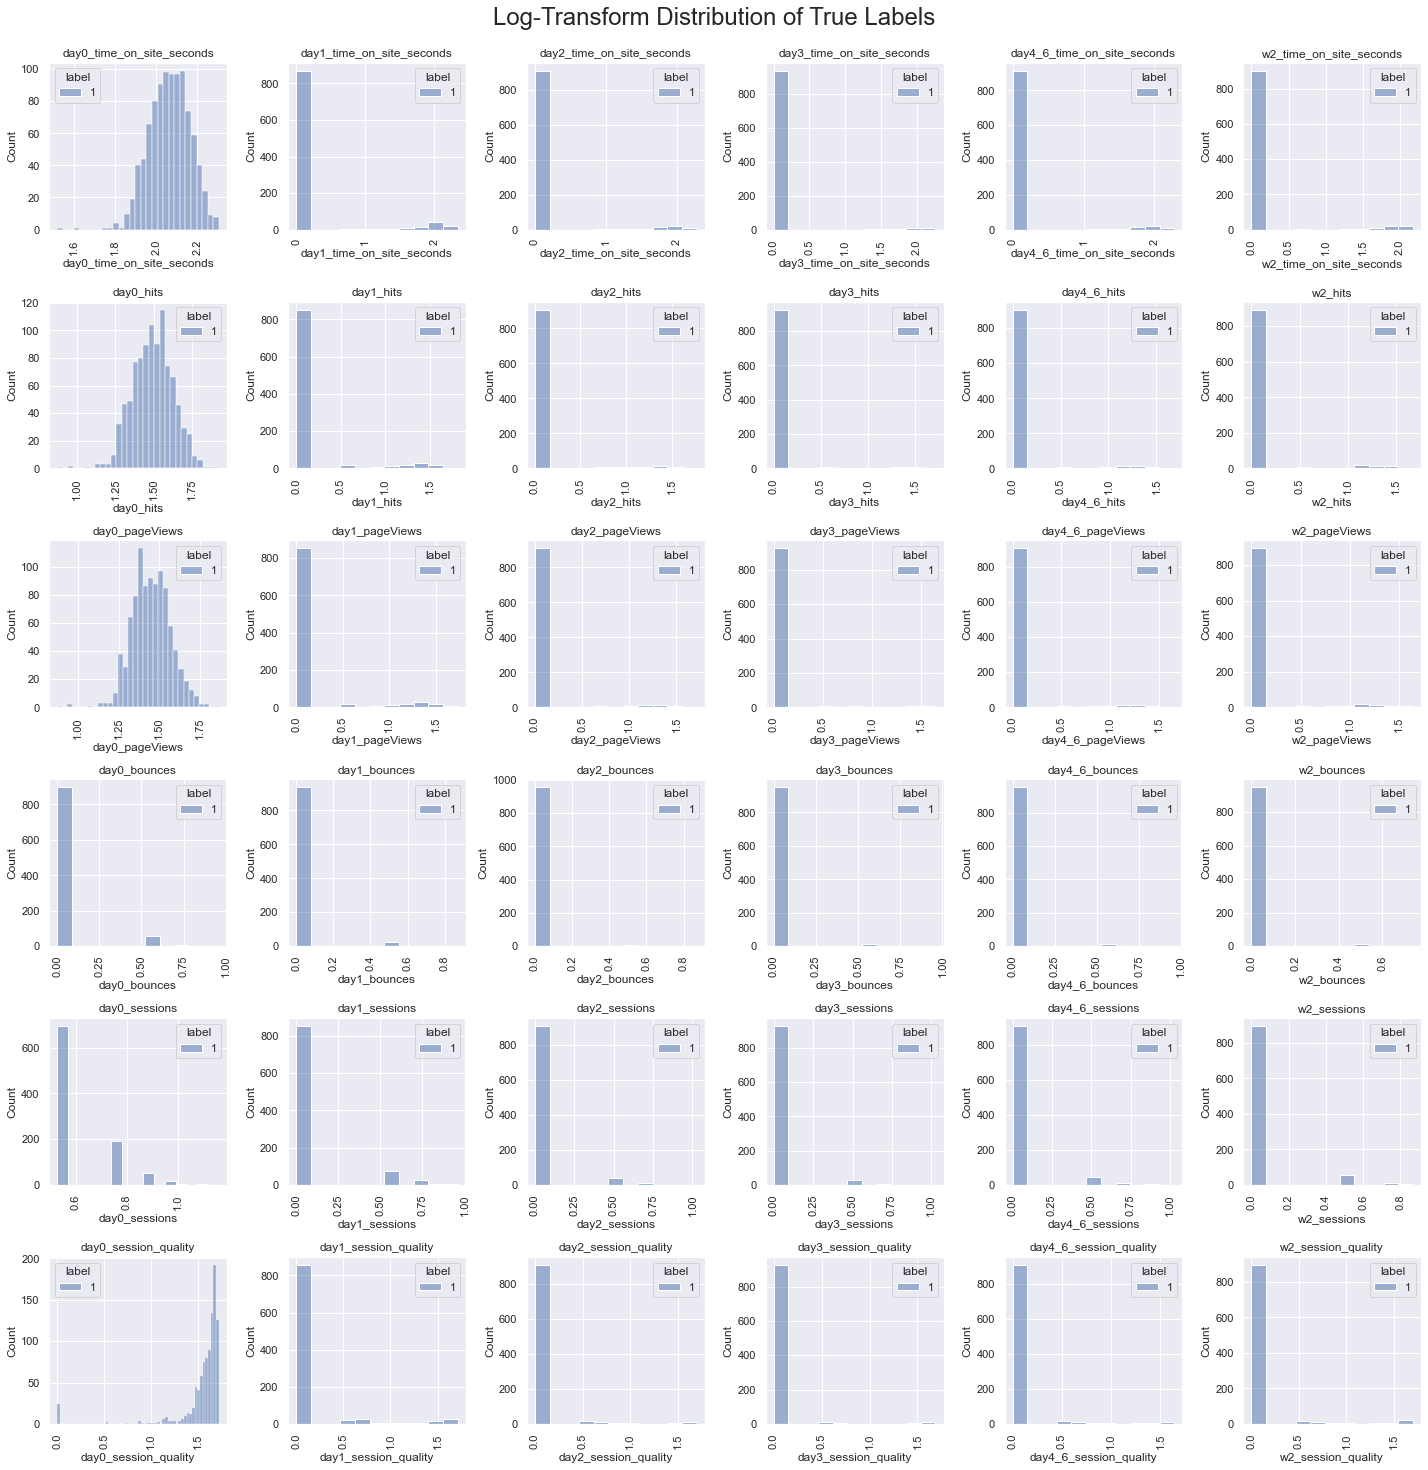

In [9]:
plot_hists(train_log[train_log.label==1], 'Log-Transform Distribution of True Labels')

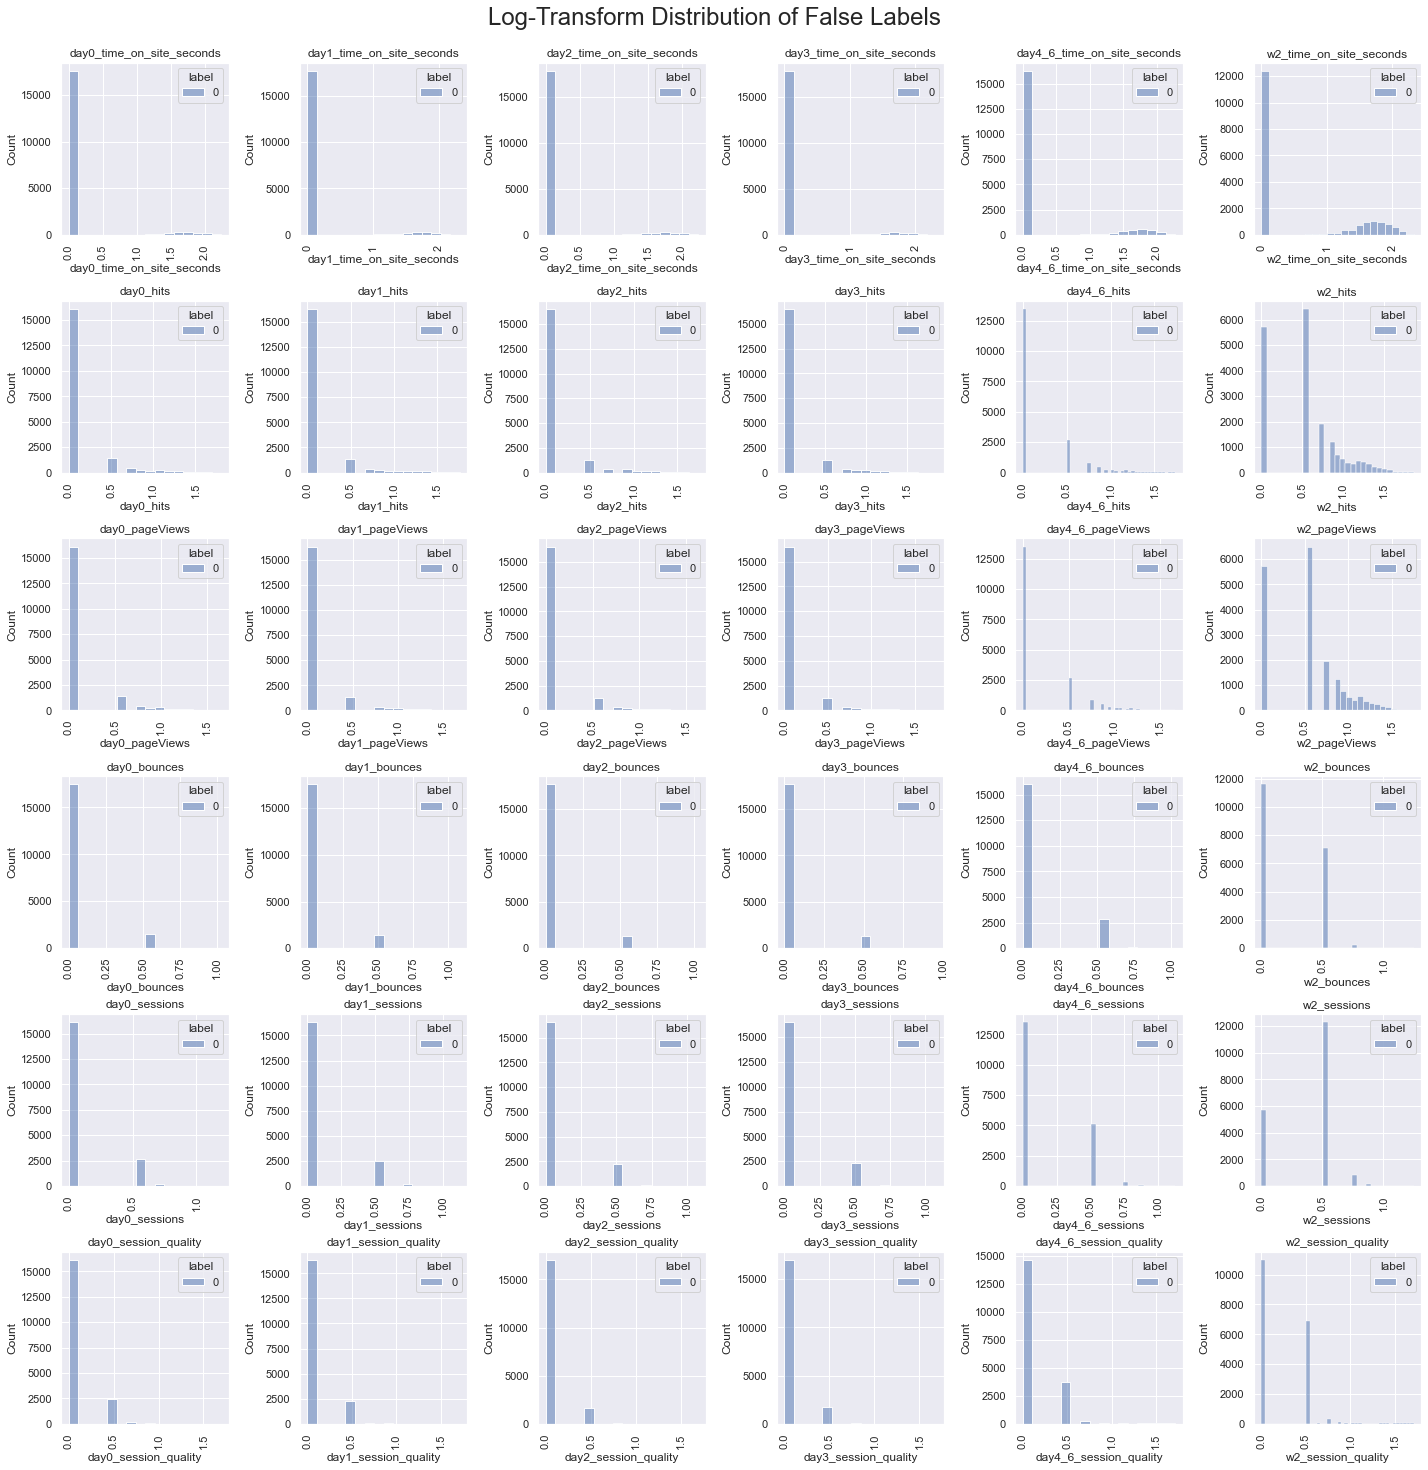

In [10]:
plot_hists(train_log[train_log.label==0], 'Log-Transform Distribution of False Labels')

Based off both the violin boxplot and the histogram, we can see that most of the features have been transformed and even reducing any significantly large or small outliers. The data is still imbalanced, however.

#### STANDARDIZATION

In [11]:
scaler = StandardScaler()

#Create a new dataframe, whilst setting the index to 'visitor_id'
train_scale = train.set_index('visitor_id')

#Save the column names (using the `columns` attribute)
train_scale_columns = train_scale.iloc[:,:-1].columns

#Fit to scaler, except for labels
scaler.fit((train_scale.iloc[:,:-1]))

#Transform the data
scaled = scaler.transform(train_scale.iloc[:,:-1])

#Create a new dataframe using the column names
train_scaled = pd.DataFrame(scaled, columns=train_scale_columns)

#insert visitor_id and labels
train_scaled.insert(0, 'visitor_id', train.visitor_id)
train_scaled['label'] = train['label']

Let's confirm that the data has been normalized

In [12]:
train_scaled.describe().T[['mean', 'std']]

mean       std
day0_time_on_site_seconds    5.509669e-14  1.000025
day1_time_on_site_seconds    7.187973e-15  1.000025
day2_time_on_site_seconds   -3.115331e-15  1.000025
day3_time_on_site_seconds    7.010883e-16  1.000025
day4_6_time_on_site_seconds  1.453753e-15  1.000025
w2_time_on_site_seconds     -2.404013e-15  1.000025
day0_hits                    3.466084e-14  1.000025
day1_hits                    2.475916e-15  1.000025
day2_hits                   -7.195734e-16  1.000025
day3_hits                   -1.492536e-16  1.000025
day4_6_hits                  7.520490e-16  1.000025
w2_hits                     -5.386061e-16  1.000025
day0_pageViews              -4.783214e-14  1.000025
day1_pageViews               3.829021e-15  1.000025
day2_pageViews              -6.538882e-16  1.000025
day3_pageViews               3.141368e-16  1.000025
day4_6_pageViews             1.140286e-15  1.000025
w2_pageViews                 2.073415e-15  1.000025
day0_bounces                -3.039155e-17  1.000025
day1_bounces                -1.233496e-15  1.000025
day2_bounces                 2.842975e-15  1.000025
day3_bounces                -3.643235e-15  1.000025
day4_6_bounces              -6.727182e-16  1.000025
w2_bounces                   7.191547e-15  1.000025
day0_sessions                2.011041e-14  1.000025
day1_sessions                1.189096e-15  1.000025
day2_sessions                8.419377e-16  1.000025
day3_sessions               -3.749324e-15  1.000025
day4_6_sessions             -8.325449e-16  1.000025
w2_sessions                  1.210423e-14  1.000025
day0_session_quality         1.563924e-14  1.000025
day1_session_quality         4.563059e-15  1.000025
day2_session_quality        -5.117136e-15  1.000025
day3_session_quality         1.303410e-15  1.000025
day4_6_session_quality       6.833942e-16  1.000025
w2_session_quality           3.811262e-15  1.000025
label                        4.828692e-02  0.214377

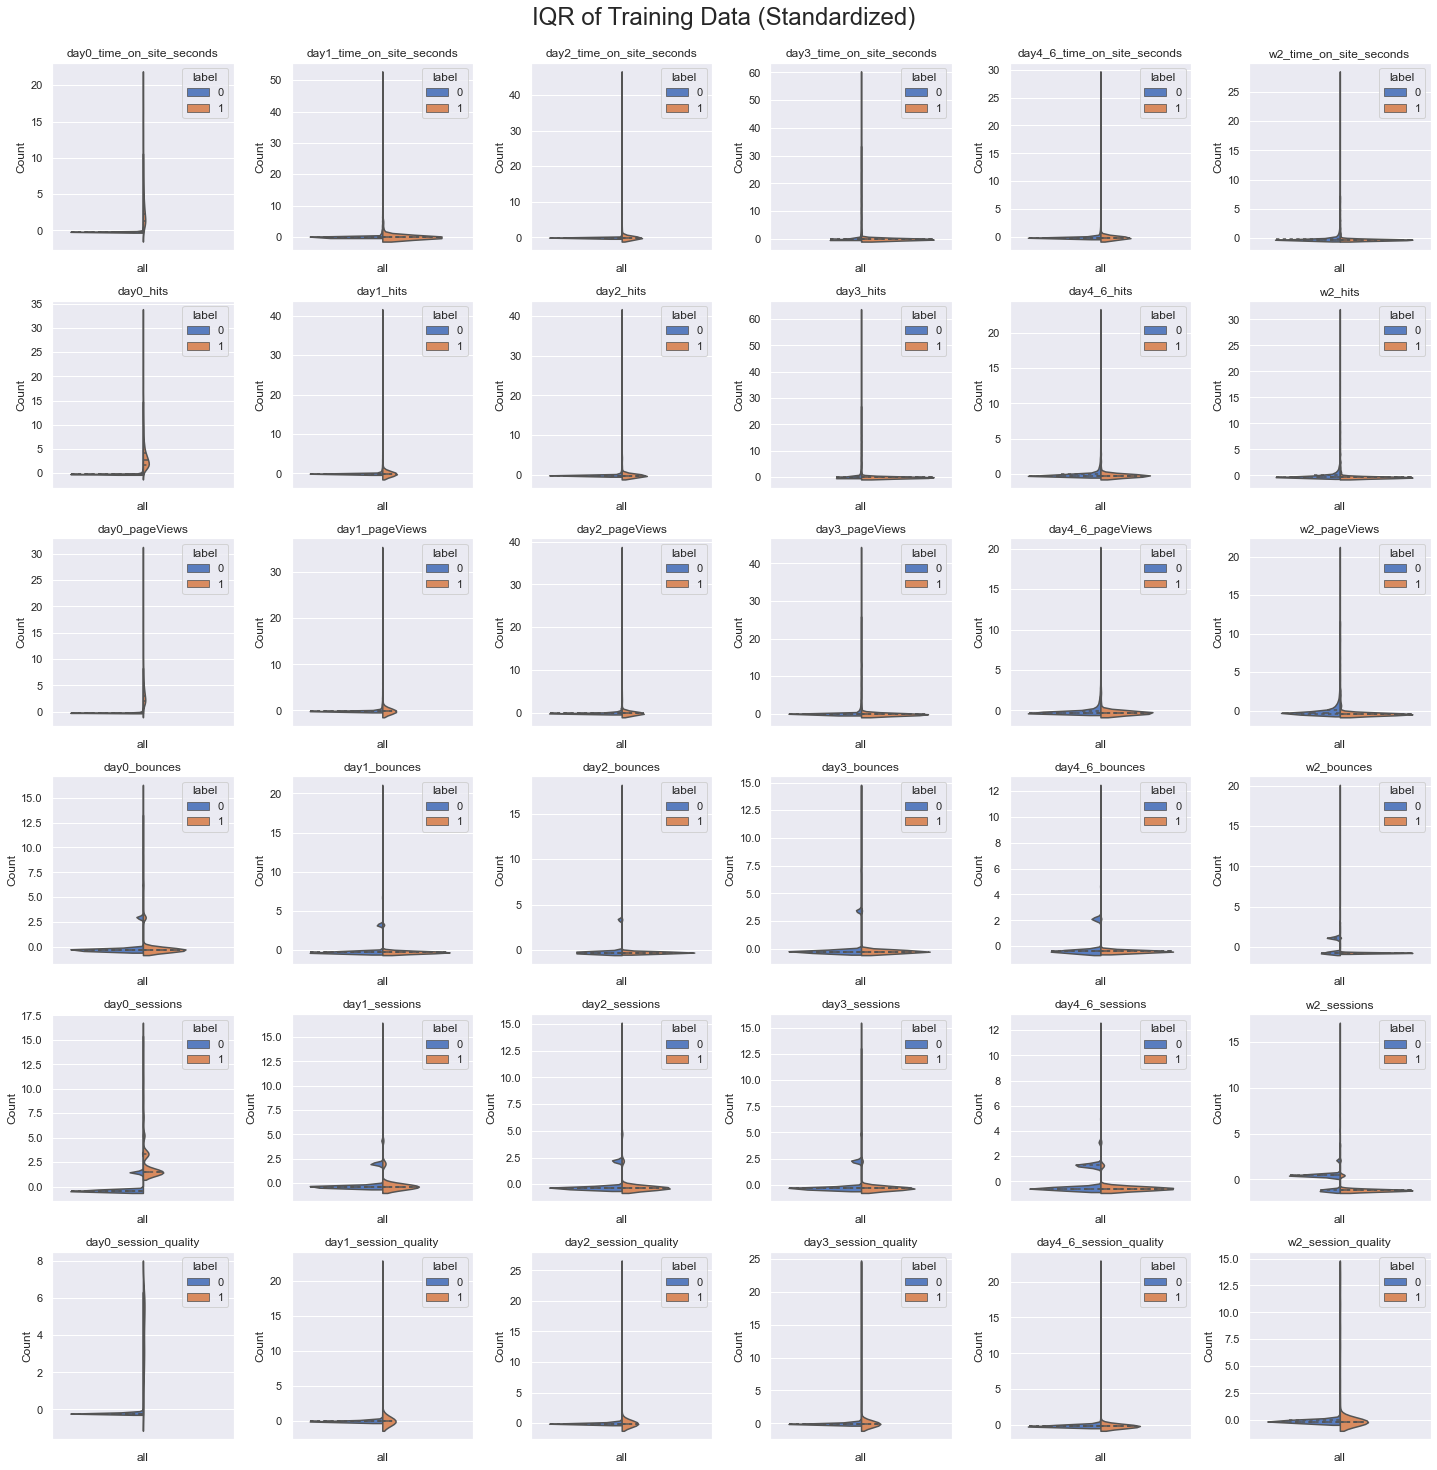

In [13]:
#create blank column to plot violin boxplot
train_scaled['all']=''
plot_violin(train_scaled, 'IQR of Training Data (Standardized)')
#remove blank column
train_scaled = train_scaled.iloc[:,:-1]

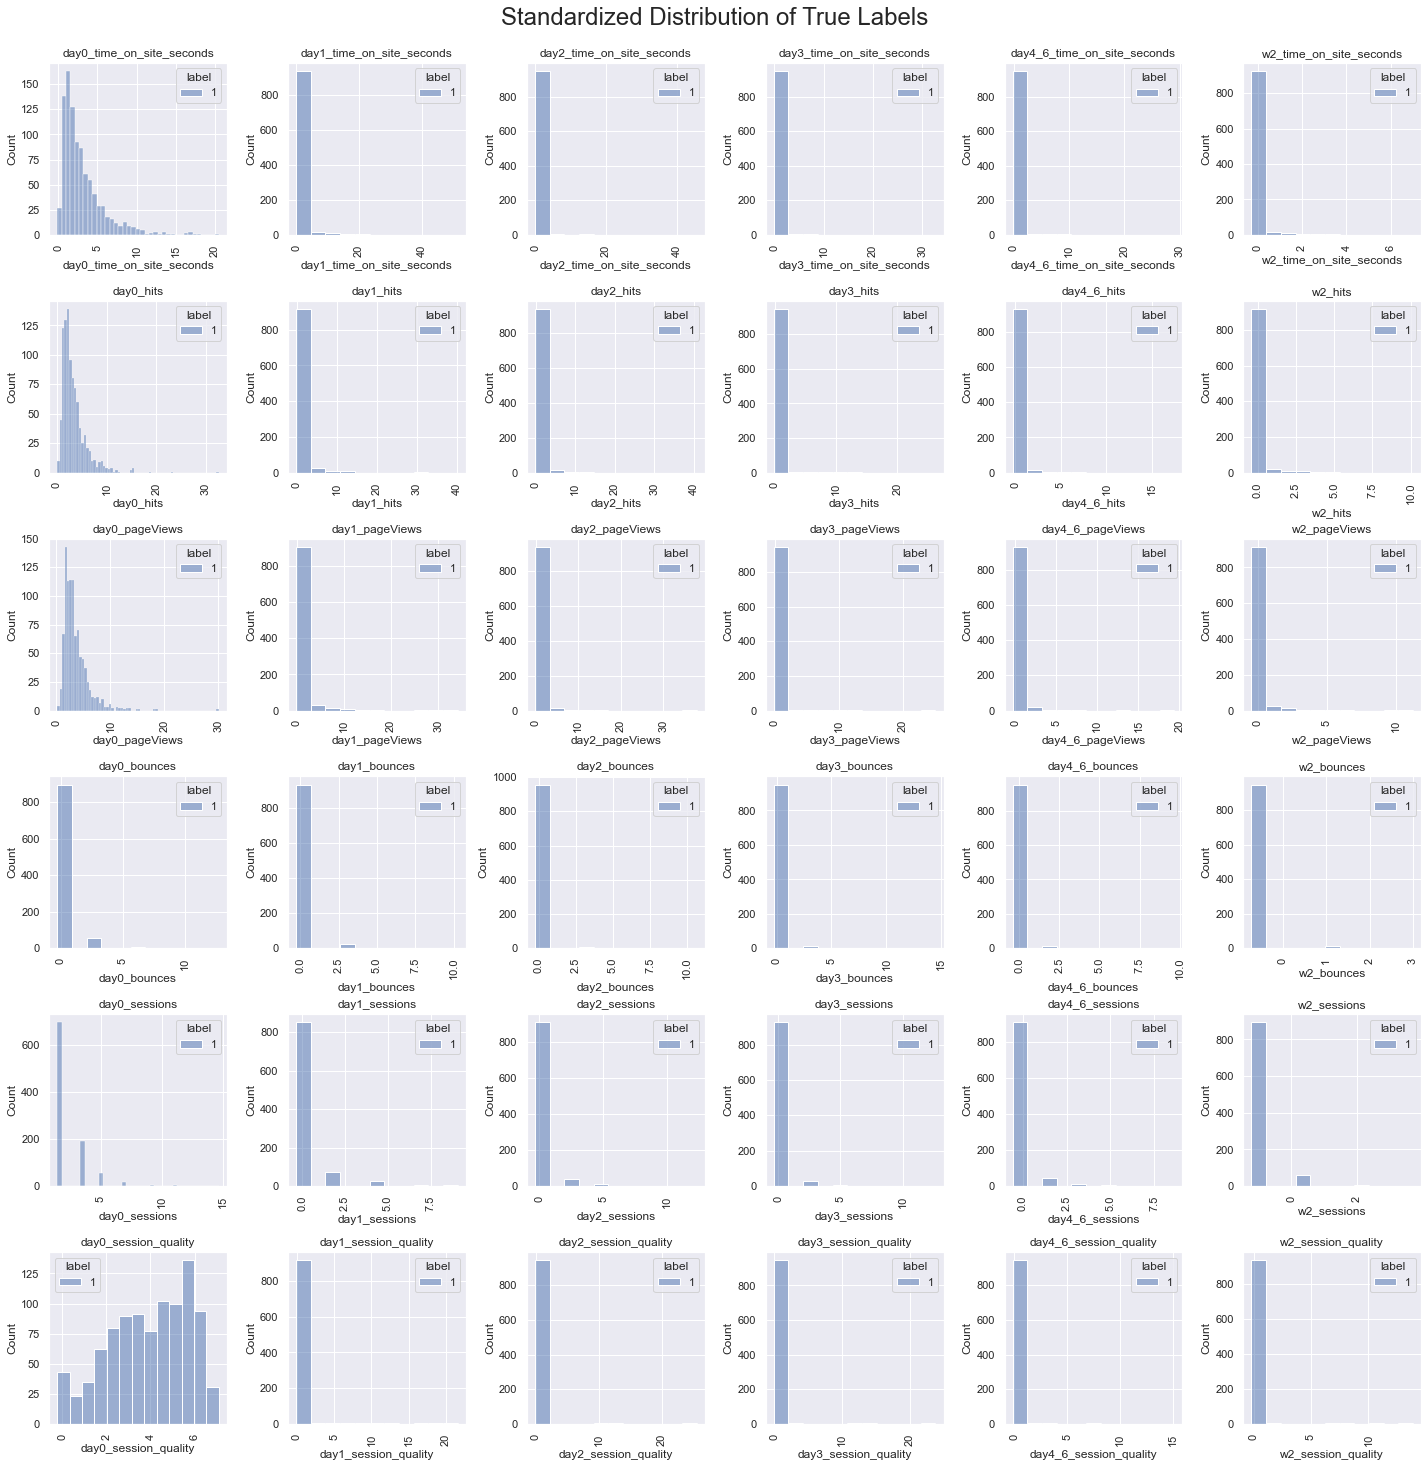

In [14]:
plot_hists(train_scaled[train_scaled.label ==1 ], 'Standardized Distribution of True Labels')

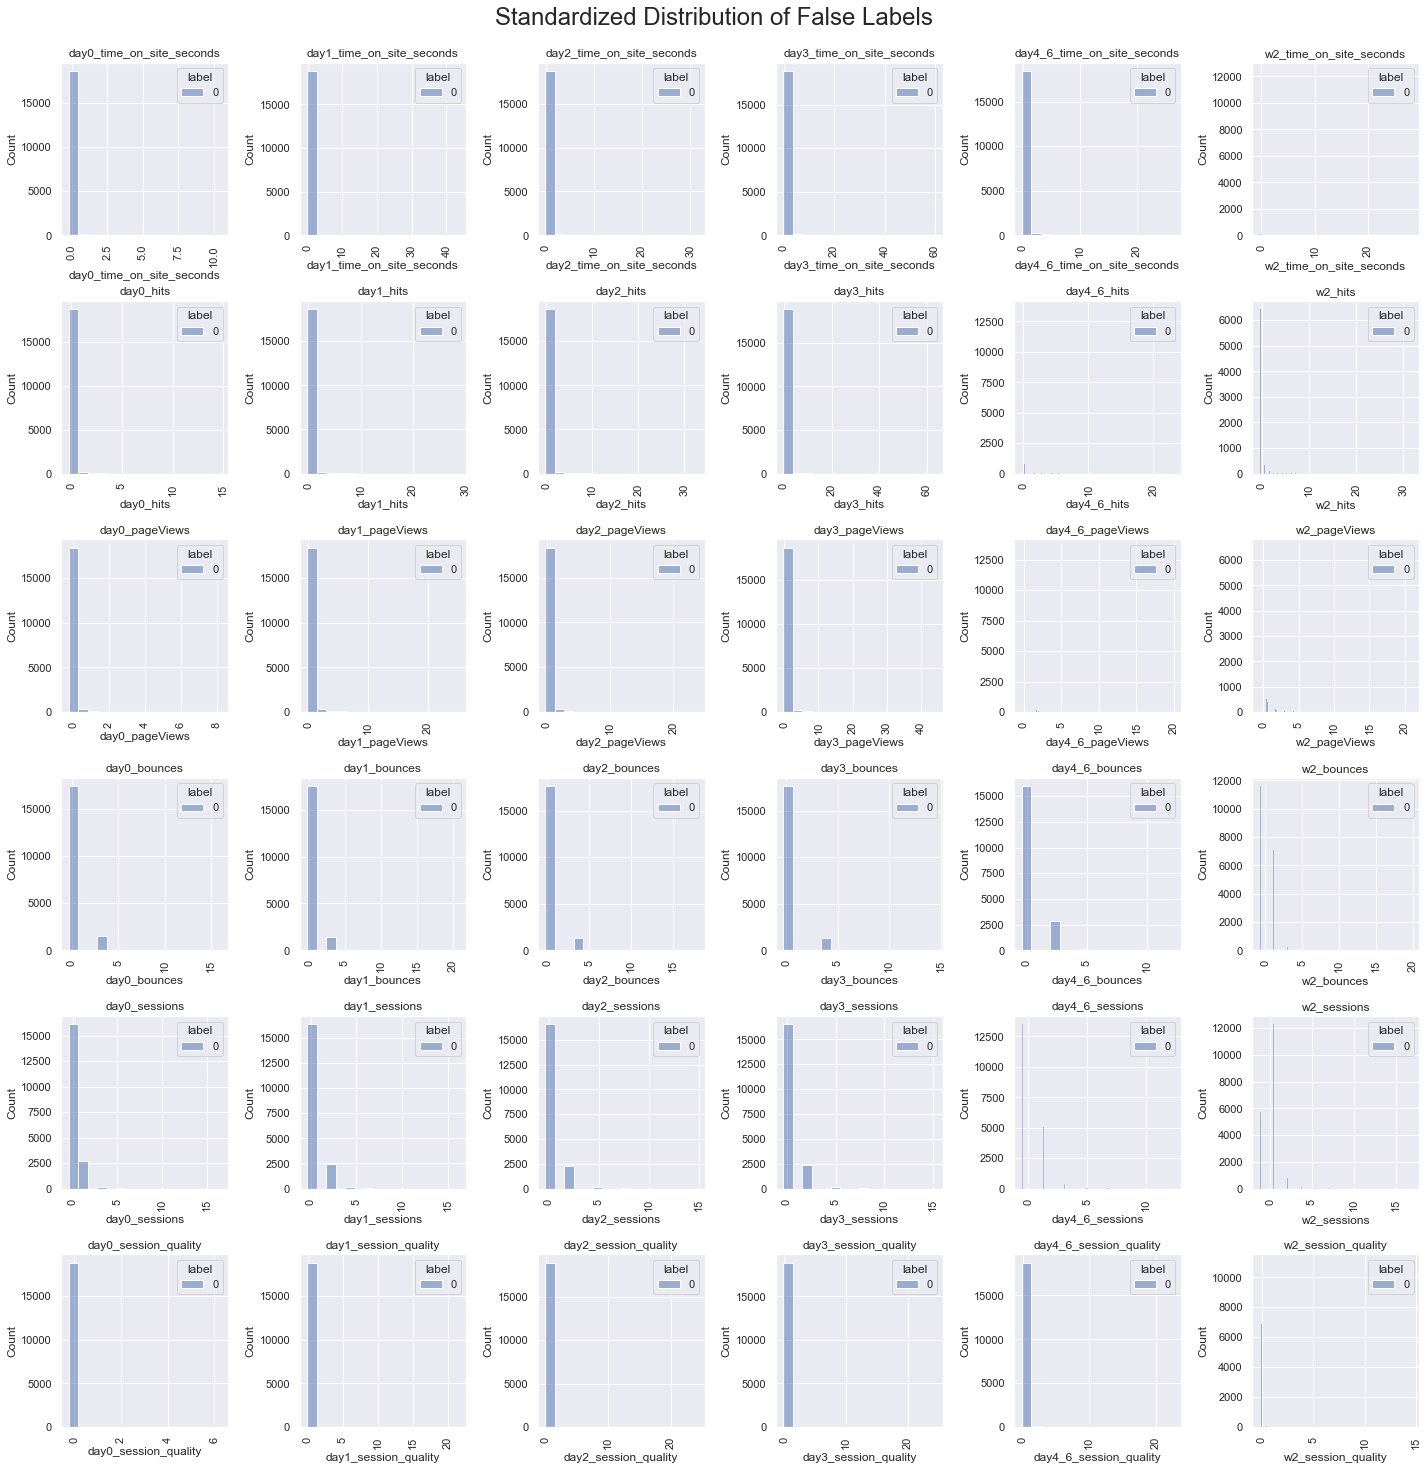

In [15]:
plot_hists(train_scaled[train_scaled.label ==0 ], 'Standardized Distribution of False Labels')

It looks like scaling the data down did normalize the standard deviation close to 1 and the mean close to 0. However, based off of the histogram and violin plot, it looks like we are still dealing with very large outliers and a skewed distribution.

# MODELING

In [119]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from catboost import Pool
import scikitplot as skplt
import shap

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

We will be using the following models for our transformations:

- CatBoost
- Random Forest
- Logistic Regression

We will be combining these in a pipeline with the transformations we examined above (__train_scaled__, and __train_log__).
First, we need to split our data.

### CATBOOST

In [17]:
def split_data(data, test_size):
    #grab all features except for the target variable
    X = data.iloc[:,:-1]
    y = data[['label']]

    #split data with random seed so we can replicate the results
    return train_test_split(X, y, test_size=test_size, random_state=42)

In [80]:
def catboost_model(X_train, X_test, y_train, y_test, iterations, type=''):
    
    #initialize the model
    model = CatBoostClassifier(iterations=iterations)

    #get categorical features
    cat_var = np.where(X_train.dtypes != np.float)[0]
    print(f'\nCategorical Variables indices : {cat_var}')

    print(f'\nTraining {type} CatBoost Model..........')

    # fit the model with the training data
    model.fit(X_train, y_train, cat_features = cat_var, plot=False)
    print('\n Model Trained')

    # predict the target on the train dataset
    y_pred_train = model.predict(X_train)
    print(f'\nTarget on train data {y_pred_train}') 

    # Accuracy Score on train dataset
    accuracy_train = accuracy_score(y_train, y_pred_train)
    print(f'\nAccuracy_score on train dataset : {accuracy_train}')

    # predict the target on the test dataset
    y_pred_test = model.predict(X_test)
    print(f'\nTarget on test data {y_pred_test}') 

    # Accuracy Score on test dataset
    accuracy_test = accuracy_score(y_test,y_pred_test)
    print(f'\nAccuracy_score on test dataset : {accuracy_test}')
    
    # Error between train and test accuracy score
    print(f'\nTrain Test Error: {abs(accuracy_test-accuracy_train)}')
    
    # Predict the probability score for each label
    proba_list = model.predict_proba(X_test)
    print(f'\nProbability score for each label: {proba_list}')
    
    # Get overall feature importance
    shap_values = model.get_feature_importance(Pool(X_test, label = y_test, cat_features = cat_var), type="ShapValues")
    shap.summary_plot(shap_values[:,:-1], X_test)
    
    return y_test, y_pred_test, proba_list

In [76]:
def lift(df):
    
    # rank the predictions made for a test set in descending order by prediction score
    df.sort_values(by='proba', ascending=False, inplace=True)
    
    # split data into deciles or groups of 10
    cuts = 10
    df['ntile'] = pd.qcut(df.proba.rank(method='first'), q=cuts, labels=range(1, cuts+1))
    
    # calculate per decile counts for positives and negatives rows
    df_new = df.copy(deep=True)
    df_new = df.groupby(['ntile','label']).proba.count().reset_index(name='count')
    
    # go from row to columns wise using pivot two join to data frames
    col = ['label','ntile', 'count']
    df_pos=df_new[df_new.label==1][col]
    df_neg=df_new[df_new.label==0][col]
    df_final = pd.merge(df_neg,df_pos, on='ntile',how='left', suffixes=('_neg','_pos'))
    
    # calculate lift 
    df_final['lift'] = df_final.count_pos/df_final.count_neg /(df_final.count_pos.sum()/df_final.count_neg.sum())
    
    return df_final

In [77]:
def plot_roc(y_test, y_pred, Model, Label='No Transformation'):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(10,10))
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label = f'{Model}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{Model} - {Label} - ROC Curve')
    plt.show()
    
    return None

In [78]:
test_size = 0.3
iterations = 50


Categorical Variables indices : [0]

Training Log Transform CatBoost Model..........
Learning rate set to 0.495485
0:	learn: 0.0861125	total: 24.7ms	remaining: 1.21s
1:	learn: 0.0241186	total: 49.3ms	remaining: 1.18s
2:	learn: 0.0165158	total: 74.4ms	remaining: 1.17s
3:	learn: 0.0146254	total: 101ms	remaining: 1.17s
4:	learn: 0.0134030	total: 134ms	remaining: 1.21s
5:	learn: 0.0125696	total: 170ms	remaining: 1.25s
6:	learn: 0.0125029	total: 204ms	remaining: 1.25s
7:	learn: 0.0120348	total: 237ms	remaining: 1.25s
8:	learn: 0.0115479	total: 270ms	remaining: 1.23s
9:	learn: 0.0109891	total: 305ms	remaining: 1.22s
10:	learn: 0.0107774	total: 345ms	remaining: 1.22s
11:	learn: 0.0104756	total: 383ms	remaining: 1.21s
12:	learn: 0.0104109	total: 434ms	remaining: 1.23s
13:	learn: 0.0093498	total: 477ms	remaining: 1.23s
14:	learn: 0.0087535	total: 518ms	remaining: 1.21s
15:	learn: 0.0086555	total: 557ms	remaining: 1.18s
16:	learn: 0.0082345	total: 595ms	remaining: 1.15s
17:	learn: 0.0080005	tot

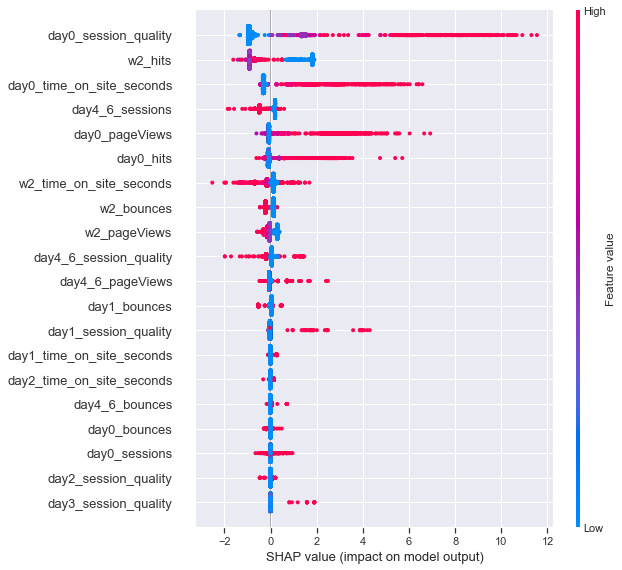

In [81]:
X_train, X_test, y_train, y_test = split_data(train_log, test_size)
y_test, y_pred, proba = catboost_model(X_train, X_test, y_train, y_test, iterations, type = 'Log Transform')

In [82]:
df = pd.DataFrame({'label' : y_pred, 'proba' : proba[:,1]})

In [83]:
lift_log = lift(df)
lift_log

label_neg ntile  count_neg  label_pos  count_pos       lift
0          0     1        599          1          0   0.000000
1          0     2        599          1          0   0.000000
2          0     3        599          1          0   0.000000
3          0     4        599          1          0   0.000000
4          0     5        599          1          0   0.000000
5          0     6        599          1          0   0.000000
6          0     7        599          1          0   0.000000
7          0     8        599          1          0   0.000000
8          0     9        599          1          0   0.000000
9          0    10        322          1        277  17.742236

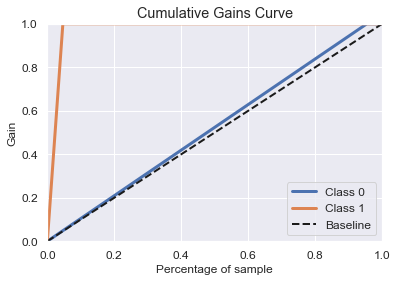

In [84]:
skplt.metrics.plot_cumulative_gain(y_pred, proba)
plt.show()

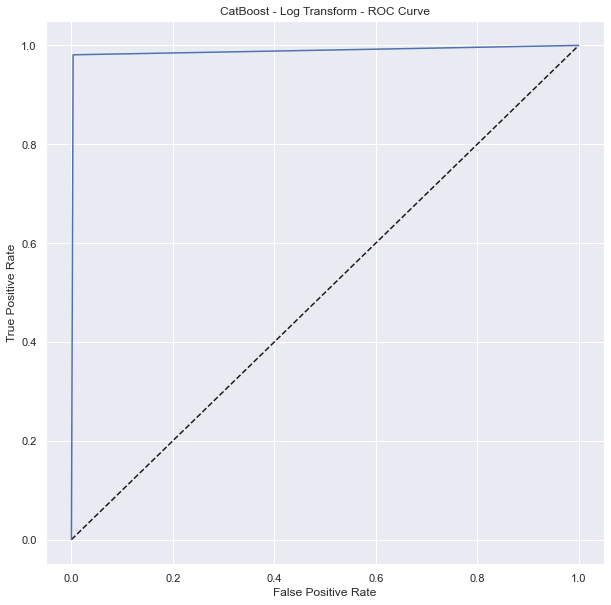

In [85]:
plot_roc(y_test, y_pred, 'CatBoost', 'Log Transform')


Categorical Variables indices : [0]

Training Standard Scaler CatBoost Model..........
Learning rate set to 0.495485
0:	learn: 0.0861125	total: 22.3ms	remaining: 1.09s
1:	learn: 0.0241186	total: 44.9ms	remaining: 1.08s
2:	learn: 0.0165158	total: 67.7ms	remaining: 1.06s
3:	learn: 0.0146254	total: 91.9ms	remaining: 1.06s
4:	learn: 0.0134030	total: 116ms	remaining: 1.04s
5:	learn: 0.0125696	total: 140ms	remaining: 1.02s
6:	learn: 0.0125029	total: 169ms	remaining: 1.04s
7:	learn: 0.0120348	total: 195ms	remaining: 1.02s
8:	learn: 0.0115479	total: 219ms	remaining: 996ms
9:	learn: 0.0109891	total: 243ms	remaining: 974ms
10:	learn: 0.0107774	total: 267ms	remaining: 947ms
11:	learn: 0.0104756	total: 291ms	remaining: 921ms
12:	learn: 0.0104109	total: 316ms	remaining: 898ms
13:	learn: 0.0093498	total: 340ms	remaining: 873ms
14:	learn: 0.0087535	total: 369ms	remaining: 861ms
15:	learn: 0.0086555	total: 394ms	remaining: 838ms
16:	learn: 0.0082345	total: 418ms	remaining: 812ms
17:	learn: 0.0080005	

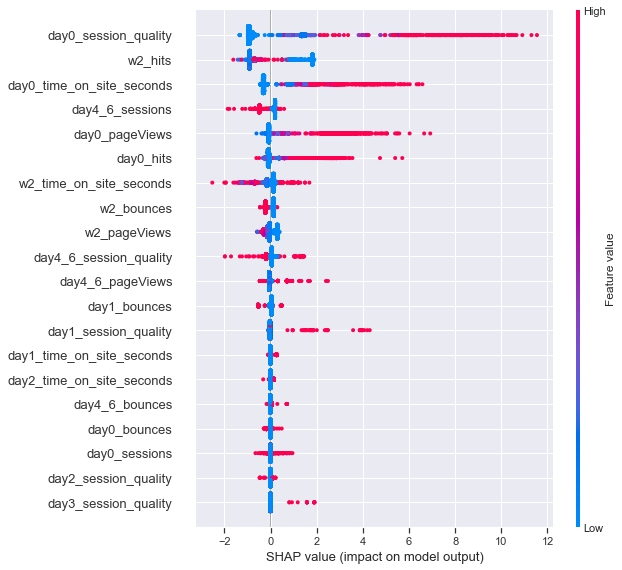

In [86]:
X_train, X_test, y_train, y_test = split_data(train_scaled, test_size)
y_test, y_pred, proba = catboost_model(X_train, X_test, y_train, y_test, iterations, type = 'Standard Scaler')

In [87]:
df = pd.DataFrame({'label' : y_pred, 'proba' : proba[:,1]})

In [88]:
lift_scale = lift(df)
lift_scale

label_neg ntile  count_neg  label_pos  count_pos       lift
0          0     1        599          1          0   0.000000
1          0     2        599          1          0   0.000000
2          0     3        599          1          0   0.000000
3          0     4        599          1          0   0.000000
4          0     5        599          1          0   0.000000
5          0     6        599          1          0   0.000000
6          0     7        599          1          0   0.000000
7          0     8        599          1          0   0.000000
8          0     9        599          1          0   0.000000
9          0    10        322          1        277  17.742236

In [ ]:
'''df = X_test.copy(deep=True)
df['y_test'] = y_test
df['y_pred'] = y_pred_test
df['pred_score'] = proba_list[:, 1]'''

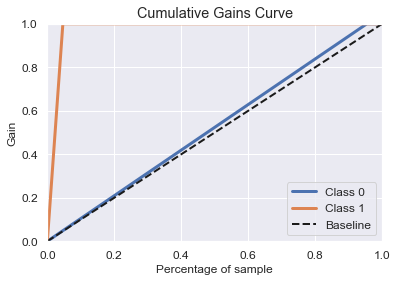

In [89]:
skplt.metrics.plot_cumulative_gain(y_pred, proba)
plt.show()

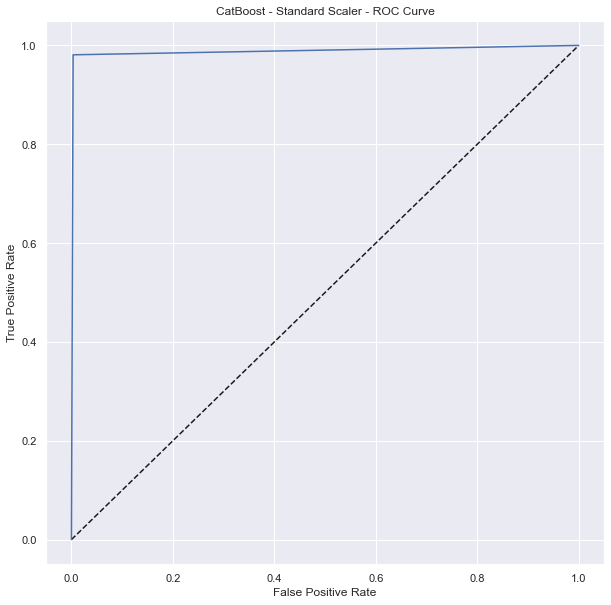

In [90]:
plot_roc(y_test, y_pred, 'CatBoost', 'Standard Scaler')

As assumed there were no differences between scaling and not scaling the data. The log transformation performs slightly worse.

### RANDOM FOREST

In [102]:
estimators = 100

In [158]:
def random_forest(X_train, X_test, y_train, y_test, estimators, type=''):
    
    # Initialize classifier 
    model = RandomForestClassifier(n_estimators=estimators, max_features="auto", random_state=42)
    
    print(f'\nTraining {type} Random Forest Model..........')
    # Fit a Random Forest model
    model.fit(X_train, y_train.values.ravel())
    print('\nModel Trained')
    
    # Predict the target on the train dataset
    y_pred_train = model.predict(X_train)
    print(f'\nTarget on train data {y_pred_train}')
    
    # Accuracy Score on train dataset
    accuracy_train = accuracy_score(y_train, y_pred_train)
    print(f'\nAccuracy_score on train dataset : {accuracy_train}')
    
    # Predict target on the test dataset
    y_pred = model.predict(X_test)
    print(f'\nTarget on test data {y_pred}') 
    
    # Accuracy score on test dataset
    accuracy_test = accuracy_score(y_test, y_pred)
    print(f'\nAccuracy_score on test dataset : {accuracy_test}')
    
    # Error between train and test accuracy score
    print(f'\nTrain Test Error: {abs(accuracy_test-accuracy_train)}')
    
    # Predict the probability score for each label
    proba_list = model.predict_proba(X_test)
    print(f'\nProbability score for each label: {proba_list}')
    
    # Get Feature Importance
    feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()
    
    return y_test, y_pred, proba_list


Training Standard Scaler Random Forest Model..........

Model Trained

Target on train data [0 0 0 ... 0 1 0]

Accuracy_score on train dataset : 1.0

Target on test data [0 0 0 ... 0 0 0]

Accuracy_score on test dataset : 0.9944908180300501

Train Test Error: 0.005509181969949872

Probability score for each label: [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


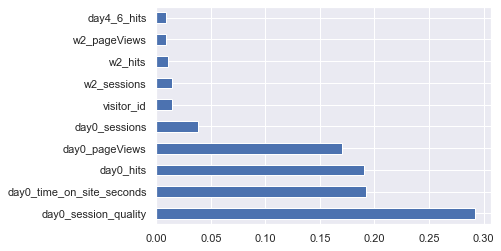

In [159]:
X_train, X_test, y_train, y_test = split_data(train_scaled, test_size)
y_test, y_pred, proba = random_forest(X_train, X_test, y_train, y_test, estimators, 'Standard Scaler')

In [160]:
df = pd.DataFrame({'label' : y_pred, 'proba' : proba[:,1]})

In [161]:
lift_rdf_scaled = lift(df)
lift_rdf_scaled

label_neg ntile  count_neg  label_pos  count_pos       lift
0          0     1        599          1          0   0.000000
1          0     2        599          1          0   0.000000
2          0     3        599          1          0   0.000000
3          0     4        599          1          0   0.000000
4          0     5        599          1          0   0.000000
5          0     6        599          1          0   0.000000
6          0     7        599          1          0   0.000000
7          0     8        599          1          0   0.000000
8          0     9        599          1          0   0.000000
9          0    10        327          1        272  17.486239

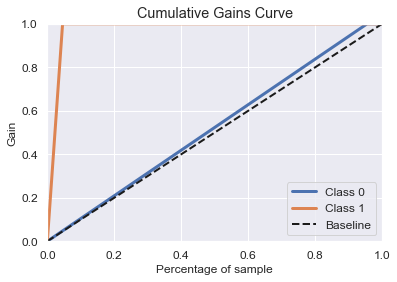

In [162]:
skplt.metrics.plot_cumulative_gain(y_pred, proba)
plt.show()

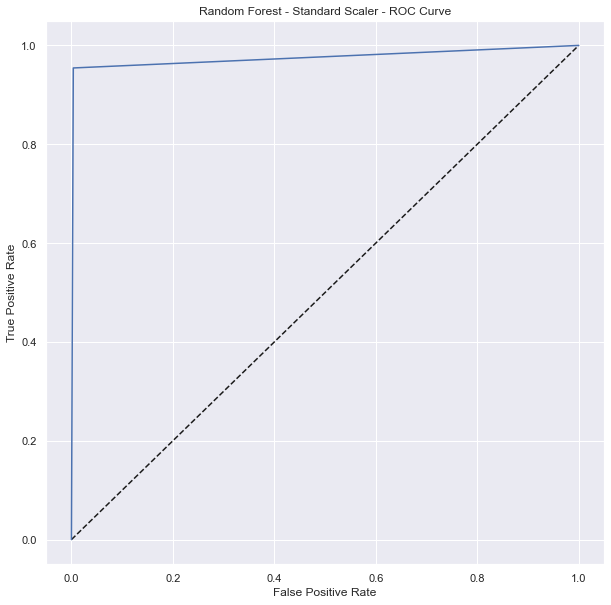

In [163]:
plot_roc(y_test, y_pred, 'Random Forest', 'Standard Scaler')


Training Log Transform Random Forest Model..........

Model Trained

Target on train data [0 0 0 ... 0 1 0]

Accuracy_score on train dataset : 1.0

Target on test data [0 0 0 ... 0 0 0]

Accuracy_score on test dataset : 0.9944908180300501

Train Test Error: 0.005509181969949872

Probability score for each label: [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


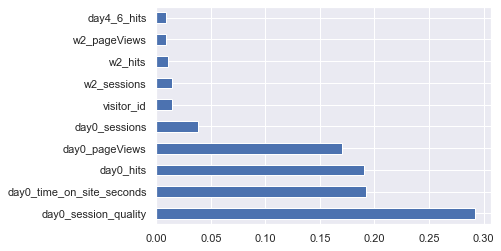

In [164]:
X_train, X_test, y_train, y_test = split_data(train_log, test_size)
y_test, y_pred, proba = random_forest(X_train, X_test, y_train, y_test, estimators, 'Log Transform')

In [165]:
df = pd.DataFrame({'label' : y_pred, 'proba' : proba[:,1]})

In [166]:
lift_rdf_log = lift(df)
lift_rdf_log

label_neg ntile  count_neg  label_pos  count_pos       lift
0          0     1        599          1          0   0.000000
1          0     2        599          1          0   0.000000
2          0     3        599          1          0   0.000000
3          0     4        599          1          0   0.000000
4          0     5        599          1          0   0.000000
5          0     6        599          1          0   0.000000
6          0     7        599          1          0   0.000000
7          0     8        599          1          0   0.000000
8          0     9        599          1          0   0.000000
9          0    10        327          1        272  17.486239

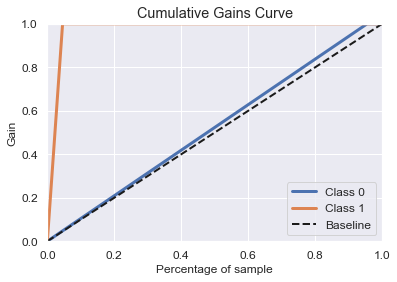

In [167]:
skplt.metrics.plot_cumulative_gain(y_pred, proba)
plt.show()

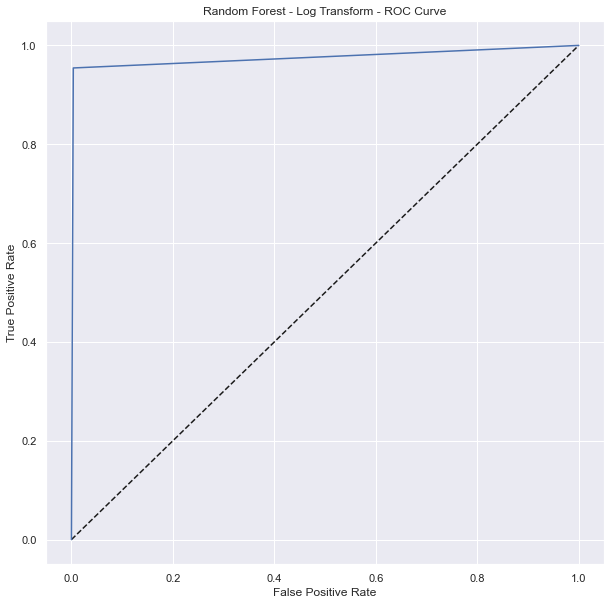

In [168]:
plot_roc(y_test, y_pred, 'Random Forest', 'Log Transform')

### LOGISTIC REGRESSION

In [188]:
from sklearn.pipeline import make_pipeline

def log_reg(X_train, X_test, y_train, y_test, type=''):
    
    # Initialize classifier 
    model = make_pipeline(StandardScaler(), LogisticRegression())
    print(f'\nTraining {type} Linear Regression Model..........')
    
    # Fit a Logistic Regression model
    model.fit(X_train, y_train.values.ravel())
    
    # Predict the target on the train dataset
    y_pred_train = model.predict(X_train)
    print(f'\nTarget on train data: {y_pred_train}')
    
    # Accuracy Score on train dataset
    accuracy_train = model.score(X_train, y_pred_train)
    print(f'\nAccuracy_score on train dataset : {accuracy_train}')
    
    # Predict target on the test dataset
    y_pred = model.predict(X_test)
    print(f'\nTarget on test data {y_pred}') 
    
    # Accuracy Score on test dataset
    accuracy_test = model.score(X_test, y_pred)
    print(f'\nAccuracy_score on test dataset : {accuracy_test}')
    
    # Error between train and test accuracy score
    print(f'\nTrain Test Error: {abs(accuracy_test-accuracy_train)}')
    
    # Predict the probability score for each label
    proba_list = model.predict_proba(X_test)
    print(f'\nProbability score for each label: {proba_list}')
        
    return y_test, y_pred, proba_list

In [189]:
X_train, X_test, y_train, y_test = split_data(train_scaled, test_size)
y_test, y_pred, proba = log_reg(X_train, X_test, y_train, y_test, 'Standard Scaler')


Training Standard Scaler Linear Regression Model..........

Target on train data: [0 0 0 ... 0 1 0]

Accuracy_score on train dataset : 1.0

Target on test data [0 0 0 ... 0 0 0]

Accuracy_score on test dataset : 1.0

Train Test Error: 0.0

Probability score for each label: [[9.99778479e-01 2.21521117e-04]
 [9.99814413e-01 1.85587190e-04]
 [9.98527825e-01 1.47217460e-03]
 ...
 [8.83115975e-01 1.16884025e-01]
 [9.99731264e-01 2.68735943e-04]
 [9.99228755e-01 7.71244510e-04]]


In [190]:
df = pd.DataFrame({'label' : y_pred, 'proba' : proba[:,1]})

In [191]:
lift_logreg_scaled = lift(df)
lift_logreg_scaled

label_neg ntile  count_neg  label_pos  count_pos       lift
0          0     1        599          1          0   0.000000
1          0     2        599          1          0   0.000000
2          0     3        599          1          0   0.000000
3          0     4        599          1          0   0.000000
4          0     5        599          1          0   0.000000
5          0     6        599          1          0   0.000000
6          0     7        599          1          0   0.000000
7          0     8        599          1          0   0.000000
8          0     9        599          1          0   0.000000
9          0    10        336          1        263  17.044643

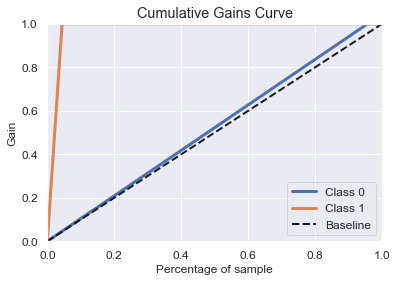

In [177]:
skplt.metrics.plot_cumulative_gain(y_pred, proba)
plt.show()

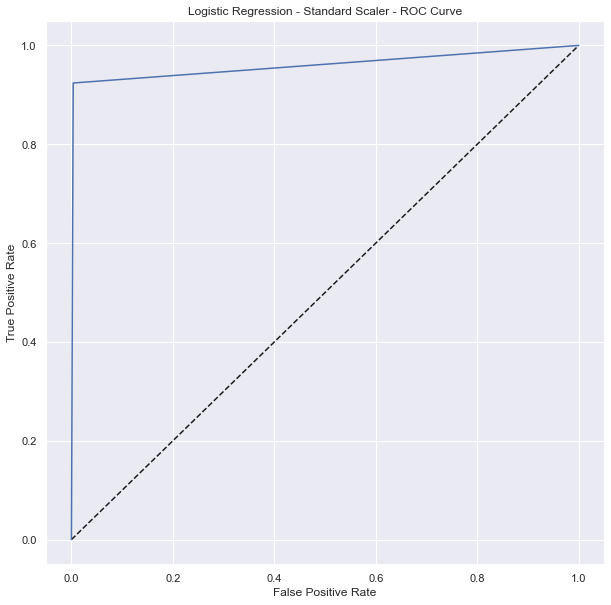

In [178]:
plot_roc(y_test, y_pred, 'Logistic Regression', 'Standard Scaler')

In [179]:
X_train, X_test, y_train, y_test = split_data(train_log, test_size)
y_test, y_pred, proba = log_reg(X_train, X_test, y_train, y_test, 'Log Transform')


Training Log Transform Linear Regression Model..........


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Target on train data: [0 0 0 ... 0 1 0]

Accuracy_score on train dataset : 1.0

Target on test data [0 0 0 ... 0 0 0]

Accuracy_score on test dataset : 1.0

Train Test Error: 0.0

Probability score for each label: [[1.00000000e+00 1.76159625e-10]
 [9.99999999e-01 6.51867627e-10]
 [9.99999998e-01 1.51042940e-09]
 ...
 [9.79171858e-01 2.08281425e-02]
 [1.00000000e+00 1.42229931e-10]
 [1.00000000e+00 3.33300772e-10]]


In [180]:
df = pd.DataFrame({'label' : y_pred, 'proba' : proba[:,1]})

In [181]:
lift_logreg_log = lift(df)
lift_logreg_log

label_neg ntile  count_neg  label_pos  count_pos       lift
0          0     1        599          1          0   0.000000
1          0     2        599          1          0   0.000000
2          0     3        599          1          0   0.000000
3          0     4        599          1          0   0.000000
4          0     5        599          1          0   0.000000
5          0     6        599          1          0   0.000000
6          0     7        599          1          0   0.000000
7          0     8        599          1          0   0.000000
8          0     9        599          1          0   0.000000
9          0    10        324          1        275  17.638889

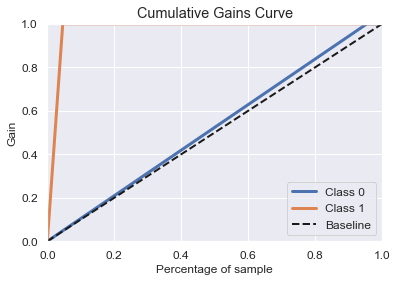

In [182]:
skplt.metrics.plot_cumulative_gain(y_pred, proba)
plt.show()

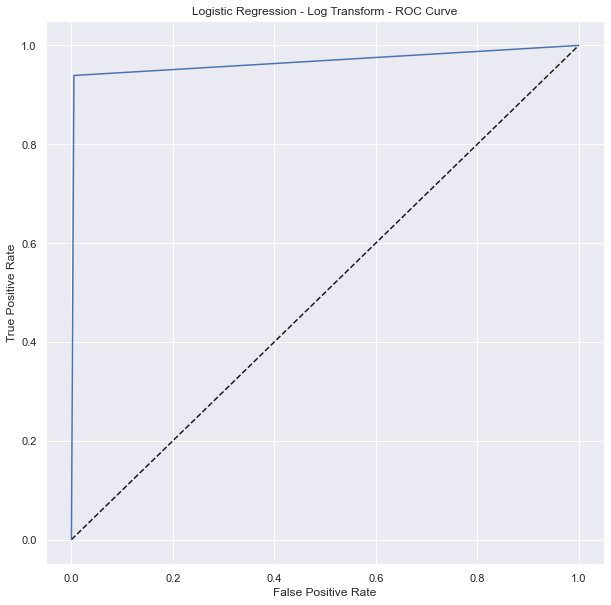

In [183]:
plot_roc(y_test, y_pred, 'Logistic Regression', 'Log Transform')

# RUNNING THE BEST MODEL ON THE VALIDATION SET

In [ ]:
def split_data(data, test_size):
    #grab all features except for the target variable
    X = data.iloc[:,:-1]
    y = data[['label']]

    #split data with random seed so we can replicate the results
    return train_test_split(X, y, test_size=test_size, random_state=42)

In [213]:
def catboost_model_val(X, y, iterations, type=''):
    
    #initialize the model
    model = CatBoostClassifier(iterations=iterations)

    #get categorical features
    cat_var = np.where(X.dtypes != np.float)[0]
    print(f'\nCategorical Variables indices : {cat_var}')

    print(f'\nTraining {type} CatBoost Model..........')

    # fit the model with the training data
    model.fit(X, y, cat_features = cat_var, plot=False)
    print('\n Model Trained')

    ''' # predict the target on the train dataset
    y_pred_train = model.predict(X_train)
    print(f'\nTarget on train data {y_pred_train}') 

    # Accuracy Score on train dataset
    accuracy_train = accuracy_score(y_train, y_pred_train)
    print(f'\nAccuracy_score on train dataset : {accuracy_train}')'''

    # predict the target on the test dataset
    y_pred_test = model.predict(X)
    print(f'\nTarget on test data {y_pred_test}') 

    # Accuracy Score on test dataset
    accuracy_test = accuracy_score(y, y_pred_test)
    print(f'\nAccuracy_score on test dataset : {accuracy_test}')
    
    # Error between train and test accuracy score
    #print(f'\nTrain Test Error: {abs(accuracy_test-accuracy_train)}')
    
    # Predict the probability score for each label
    proba_list = model.predict_proba(X)
    print(f'\nProbability score for each label: {proba_list}')
    
    # Get overall feature importance
    shap_values = model.get_feature_importance(Pool(X, label = y, cat_features = cat_var), type="ShapValues")
    shap.summary_plot(shap_values[:,:-1], X)
    
    return y, y_pred_test, proba_list

In [205]:
#upload training set and change dtypes for visitor_id and label to a categorical object
val = pd.read_csv('data/val_20170301_to_20170314', index_col=0, dtype={'visitor_id': 'object'})
val.head()

visitor_id  day0_time_on_site_seconds  day1_time_on_site_seconds  \
0  2801499422088453532                      139.0                        NaN   
1  9697633748020539508                      284.0                        NaN   
2    49628940161747998                      171.0                        NaN   
3  6056987916550791423                      178.0                        NaN   
4  3996687359433676152                      222.0                        NaN   

   day2_time_on_site_seconds  day3_time_on_site_seconds  \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                        NaN                        NaN   
3                        NaN                        NaN   
4                        NaN                        NaN   

   day4_6_time_on_site_seconds  w2_time_on_site_seconds  day0_hits  day1_hits  \
0                          NaN                      NaN        2.0        NaN   
1                          NaN                      NaN        6.0        NaN   
2                          NaN                      NaN        9.0        NaN   
3                          NaN                      NaN       10.0        NaN   
4                          NaN                      NaN       10.0        NaN   

   day2_hits  ...  day3_sessions  day4_6_sessions  w2_sessions  \
0        NaN  ...            NaN              NaN          NaN   
1        NaN  ...            NaN              NaN          NaN   
2        NaN  ...            NaN              NaN          NaN   
3        NaN  ...            NaN              NaN          NaN   
4        NaN  ...            NaN              NaN          NaN   

   day0_session_quality  day1_session_quality  day2_session_quality  \
0                   0.0                   NaN                   NaN   
1                   0.0                   NaN                   NaN   
2                   0.0                   NaN                   NaN   
3                   0.0                   NaN                   NaN   
4                   0.0                   NaN                   NaN   

   day3_session_quality  day4_6_session_quality  w2_session_quality  label  
0                   NaN                     NaN                 NaN      1  
1                   NaN                     NaN                 NaN      1  
2                   NaN                     NaN                 NaN      1  
3                   NaN                     NaN                 NaN      1  
4                   NaN                     NaN                 NaN      1  

[5 rows x 38 columns]

In [206]:
val.label.value_counts()/len(val.label)

0    0.981658
1    0.018342
Name: label, dtype: float64

In [208]:
scaler = StandardScaler()

#Create a new dataframe, whilst setting the index to 'visitor_id'
val_scale = val.set_index('visitor_id')

#Save the column names (using the `columns` attribute)
val_scale_columns = val_scale.iloc[:,:-1].columns

#Fit to scaler, except for labels
scaler.fit((val_scale.iloc[:,:-1]))

#Transform the data
scaled = scaler.transform(val_scale.iloc[:,:-1])

#Create a new dataframe using the column names
val_scaled = pd.DataFrame(scaled, columns=val_scale_columns)

#insert visitor_id and labels
val_scaled.insert(0, 'visitor_id', train.visitor_id)
val_scaled['label'] = val['label']
val = val_scaled

In [209]:
val.fillna(0, inplace=True)


Categorical Variables indices : [0]

Training Validation CatBoost Model..........
Learning rate set to 0.5
0:	learn: 0.0652369	total: 24.9ms	remaining: 1.22s
1:	learn: 0.0221795	total: 49.7ms	remaining: 1.19s
2:	learn: 0.0139714	total: 75.1ms	remaining: 1.18s
3:	learn: 0.0115234	total: 101ms	remaining: 1.16s
4:	learn: 0.0108850	total: 139ms	remaining: 1.25s
5:	learn: 0.0104192	total: 170ms	remaining: 1.24s
6:	learn: 0.0098168	total: 195ms	remaining: 1.2s
7:	learn: 0.0094714	total: 221ms	remaining: 1.16s
8:	learn: 0.0092527	total: 246ms	remaining: 1.12s
9:	learn: 0.0085440	total: 272ms	remaining: 1.09s
10:	learn: 0.0084023	total: 297ms	remaining: 1.05s
11:	learn: 0.0081067	total: 322ms	remaining: 1.02s
12:	learn: 0.0079336	total: 348ms	remaining: 990ms
13:	learn: 0.0078563	total: 372ms	remaining: 956ms
14:	learn: 0.0074814	total: 402ms	remaining: 938ms
15:	learn: 0.0073742	total: 427ms	remaining: 908ms
16:	learn: 0.0071821	total: 466ms	remaining: 905ms
17:	learn: 0.0068483	total: 491ms

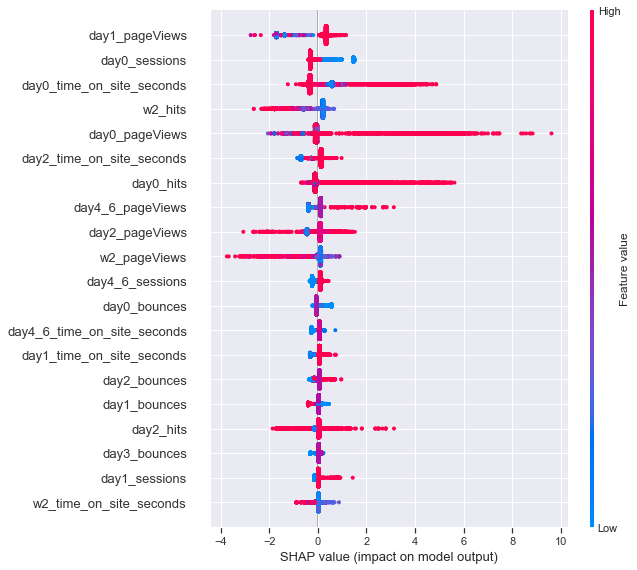

In [216]:
y_test, y_pred, proba = catboost_model_val(val.iloc[:,:-1], val[['label']], iterations, 'Validation')

In [217]:
df = pd.DataFrame({'label' : y_pred, 'proba' : proba[:,1]})

In [218]:
lift_val = lift(df)
lift_val

label_neg ntile  count_neg  label_pos  count_pos       lift
0          0     1       1936          1          0   0.000000
1          0     2       1935          1          0   0.000000
2          0     3       1936          1          0   0.000000
3          0     4       1935          1          0   0.000000
4          0     5       1936          1          0   0.000000
5          0     6       1935          1          0   0.000000
6          0     7       1935          1          0   0.000000
7          0     8       1936          1          0   0.000000
8          0     9       1935          1          0   0.000000
9          0    10       1584          1        352  11.996843

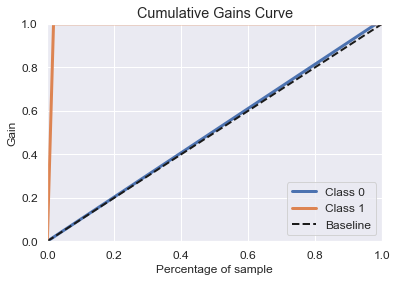

In [219]:
skplt.metrics.plot_cumulative_gain(y_pred, proba)
plt.show()

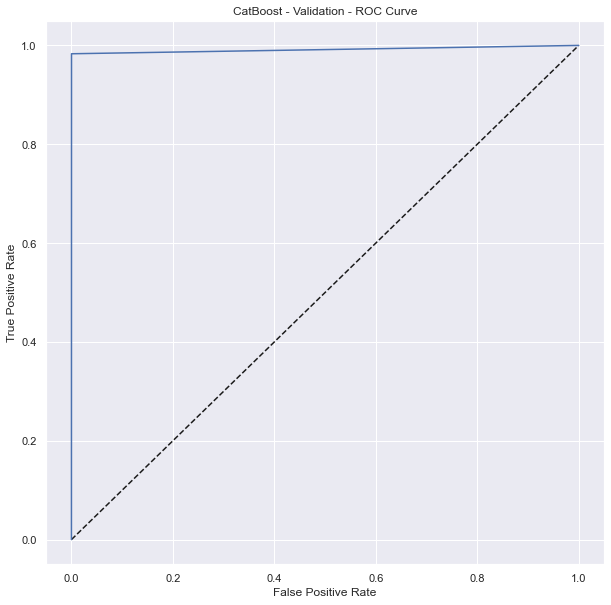

In [220]:
plot_roc(y_test, y_pred, 'CatBoost', 'Validation')